# Relaxation Runge--Kutta

In [1]:
# Loading/installing packages

# This is the basic package in python with all the numerical functions
try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np

# This package allows to  plot
try:
    import matplotlib.pyplot as plt 
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt 

#This package already implemented some functions for Runge Kutta and multistep methods
try:
    from nodepy import rk
except ImportError:
    %pip install nodepy
    from nodepy import rk

In [2]:
# Download collection of ODE problems
try:
    from ODEproblems import ODEproblem
except ImportError:
    ![ -f ODEproblems.py ] || wget https://github.com/accdavlo/HighOrderODESolvers/raw/master/ODEproblems.py -O ODEproblems.py
    from ODEproblems import ODEproblem

The relaxation technique is a modification of high order accurate time integration methods which allow to conserve or dissipate some quantities of interest, such as entropy or energy, that physically would be conserved or dissipated.

Consider again 

$$
y'=F(y)
$$

and suppose that we know that the kinetic energy is conserved (dissipated), i.e.

$$
\frac{d}{dt} \frac{1}{2} \langle y, y \rangle = \langle y, y' \rangle = \langle y, F(y) \rangle \stackrel{(\leq)}{=} 0.
$$

This is the case of many examples we have seen before, e.g. Dahlquist's equation with negative coefficient, nonlinear oscillator, damped nonlinear oscillator, semidiscretized conservation laws (linear transport equation, Burgers' equation).

More in general we might have a nonquadratic quantity that is conserved (entropy, momentum, total energy (kinetic+potential))

$$
\frac{d}{dt}\eta(y)= \langle \partial_y \eta(y), y' \rangle = \langle \partial_y \eta(y), F(y) \rangle \stackrel{(\leq)}{=} 0.
$$

This is the case of nonlinear pendulum, Lotka-Volterra, other conservation laws (Euler's equation). 

Several relaxation methods have been proposed in the last 3 years: the relaxation Runge Kutta [Ketcheson 2019](https://arxiv.org/abs/1905.09847) (energy), [Ketcheson2020](https://arxiv.org/abs/1909.13215) (non autonomous systems), [Ranocha 2019](https://arxiv.org/abs/1905.09129) (general entropy)  and multistep methods [Ranocha 2020](https://arxiv.org/abs/2003.03012), all originally inspired by [Del Buono 2002](https://www.sciencedirect.com/science/article/pii/S0377042701003983?via%3Dihub).


Here, we present the version in case of kinetic energy for explicit RK methods 
$$
\begin{array}
{c|c}
c&A\\
\hline
& b^T
\end{array}
$$
where $A\in \mathbb R^{S\times S},\, b,c\in\mathbb R^S$, in the following formulation

$$
\begin{cases}
y^{(k)}=y^n + \Delta t \sum_{j=1}^S a_{kj} F(t^n+c_j\Delta t,y^{(j)}), \quad k=1,\dots, S,\\
y^{n+1} = y^n+ \Delta t \sum_{j=1}^S b_{j} F(t^n+c_j\Delta t,y^{(j)})
\end{cases}
$$

The technique consists of modifying the timestep by a constant $\gamma\approx 1$ which moves forward or backward the solution on the line drawn from $y^n$ to $y^{n+1}$, in order to verify a well known conservation or dissipation scalar constraint, e.g. energy or entropy. The idea is to find a certain $\gamma_n$ and $y^{n+1}_\gamma$ that approximates $y(t^n+\gamma_n \Delta t)$ and conserves the entropy conservation/dissipation. 

We start discussing the kinetic energy case.

Let us consider the energy defined by the scalar product $\langle y,y \rangle$ that we physically know it is conserved or dissipated. Moreover, we know that analytically $\langle F(y), y \rangle \leq 0$ or $=0$.
Then, we define 

\begin{cases}
y^{(k)}=y^n + \Delta t \sum_{j=1}^S a_{kj} F(t^n+c_j\Delta t,y^{(j)}), \quad k=1,\dots, S,\\
y^{n+1}_\gamma = y^n+ \gamma\Delta t \sum_{j=1}^S b_{j} F(t^n+c_j\Delta t,y^{(j)})
\end{cases}

and, defining with $\Delta y:=	y^{n+1} -y^n$, we develop the scalar product

$$
\begin{align*}
	&\langle y^{n+1}_\gamma,y^{n+1}_\gamma \rangle \\= &	\langle y^{n},y^{n} \rangle + 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle \\
	=& 	\langle y^{n},y^{n} \rangle +2 \gamma\Delta t \sum_{j=1}^S b_j \underbrace{\langle y^{(j)},  f({y}^{(j)}) \rangle}_{\leq 0}\\
	&-2 \gamma \Delta t \sum_{j=1}^S b_j\langle {y}^{(j)}, f({y}^{(j)}) \rangle+ 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f( y^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle\\
	=& 	\langle y^{n},y^{n} \rangle +2 \gamma\Delta t \sum_{j=1}^S b_j \underbrace{\langle y^{(j)},  f({y}^{(j)}) \rangle}_{\leq 0}\\
	&-2 \gamma \Delta t \sum_{j=1}^S b_j\langle {y}^{(j)}-y^n, f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle\\
	=& 	\langle y^{n},y^{n} \rangle +2 \gamma\Delta t \sum_{j=1}^S b_j \underbrace{\langle y^{(j)},  f({y}^{(j)}) \rangle}_{\leq 0}\\
	&-2 \gamma \Delta t^2 \sum_{j=1}^S \sum_k b_j a_{jk}\langle f(y^{(k)}), f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle,
\end{align*}
$$

where we know from the conservation or dissipation property that the second term is equal or smaller than 0, respectively, if $b_j \geq 0$ for all $s$. Hence, we impose the rest of the equation to be equal to 0, by setting 

$$
\begin{align*}
 &-2 \gamma \Delta t \sum_{j=1}^S b_j\langle y^{(j)}, f(y^{(j)}) \rangle+ 2 \gamma \langle y^{n}, \Delta t \sum_{j=1}^S b_j f({y}^{(j)}) \rangle + \gamma^2 \langle \Delta y , \Delta y \rangle =0\\
 \Leftrightarrow & \gamma = \frac{2 \Delta t \sum_{j=1}^S b_j \langle {y}^{(j)}, f({y}^{(j)}) \rangle -2   \langle y^n, \Delta t \sum_{j=1}^S b_j f({y}^{(j)})\rangle}{\langle \Delta y , \Delta y \rangle}\\
 \Leftrightarrow & \gamma = \frac{2 \Delta t \sum_{j=1}^S b_j \langle {y}^{(j)}-y^n, f({y}^{(j)}) \rangle }{\langle \Delta y , \Delta y \rangle}
 \end{align*}
$$

**Remark** The final timestep we perform is not of size $\Delta t$, but it is of size $\gamma \Delta t$, hence we need also to update the new time as $t^{n+1}=t^n+\gamma \Delta t$

In [3]:
## explicit RK method
def explicitRelaxRK(flux, y_0, dt0, T_fin, KtMax,  A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # input: y_0 the initial condition
    # dt0 is the basic time interval, that will be modified along the steps
    # T_fin is the final time
    # KtMax is maximum number of timesteps
    # input: A,b,c are matrix and vectors of RK methods
    dim=len(y_0)          # S
    y=np.zeros((dim,KtMax))    # initializing the variable of solutions
    tspan=np.zeros(KtMax)      # times will be stored here
    gammas = np.zeros(KtMax)   # Gamma relaxation coefficients
    time= 0.
    gammas[0] = 1
    n=0                        # Time step index
    tspan[0] = time
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    while(time<T_fin and n<KtMax):    # n=0,..., N-1
        delta_t=min(dt0,T_fin-time)
        #Classic RK step
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] = u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        yn1=y[:,n]
        for j in range(S):
            yn1=yn1+delta_t*b[j]*Fu[:,j]
        # Compute the relaxation gamma
        deltay = yn1-y[:,n]
        sumBScal=0.
        for j in range(S):
            sumBScal=sumBScal + b[j]* np.dot(u[:,j]-y[:,n],Fu[:,j])
        gamma = 2* delta_t* sumBScal/np.dot(deltay,deltay)
        # Update the n+1 values
        y[:,n+1]=y[:,n] +gamma*deltay
        if (time+delta_t<T_fin -10**-16):
            time = time + gamma*delta_t
        else:
            time=T_fin
        tspan[n+1]=time
        gammas[n+1]=gamma
        n=n+1
        
    return tspan[:n+1], y[:,:n+1] , gammas[:n+1]

In [4]:
## explicit RK method
def explicitRK(flux, tspan, y_0, A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # input: y_0 the initial condition
    # input: A,b,c are matrix and vectors of RK methods
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    for n in range(N_time-1):    # n=0,..., N-1
        delta_t=tspan[n+1]-tspan[n]
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] =u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        y[:,n+1]=y[:,n]
        for j in range(S):
            y[:,n+1]=y[:,n+1]+delta_t*b[j]*Fu[:,j]
    return tspan, y 

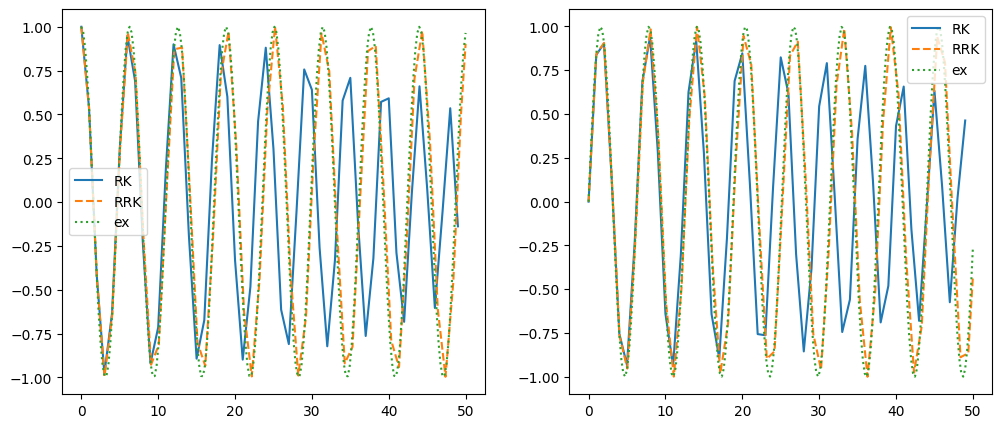

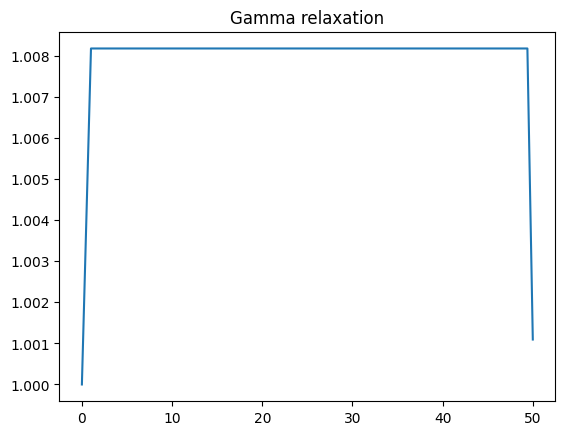

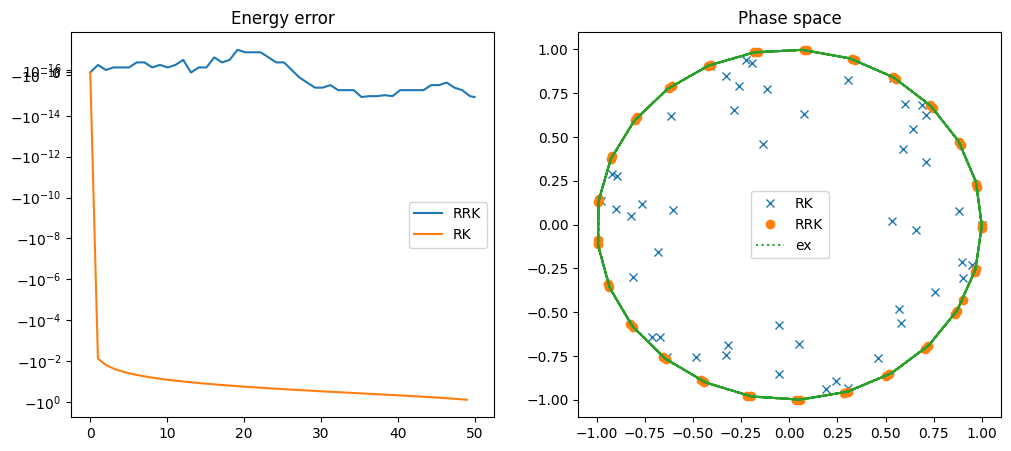

In [5]:
pr=ODEproblem("nonLinearOscillator") #"nonLinearOscillatorDamped"
dt0=1  #0.5
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRK(pr.flux, pr.u0, dt0, pr.T_fin, np.int64(pr.T_fin//dt0*3),  rk44.A, rk44.b, rk44.c)

tEx=np.linspace(0,pr.T_fin, 200)
uEx=np.zeros((uu.shape[0], len(tEx)))
for k in range(len(tEx)):
    uEx[:,k] = pr.exact(pr.u0,tEx[k])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")
plt.plot(tEx,uEx[0,:],":",label="ex")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")
plt.plot(tEx,uEx[1,:],":",label="ex")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[np.dot(uuR[:,k],uuR[:,k])-np.dot(pr.exact(pr.u0,ttR[k]),pr.exact(pr.u0,ttR[k])) for k in range(len(ttR))]
errorEnRK=[np.dot(uu[:,k],uu[:,k])-np.dot(pr.exact(pr.u0,tt[k]),pr.exact(pr.u0,tt[k])) for k in range(len(tt))]
plt.plot(ttR,errorEnRRK,label="RRK")
plt.plot(tt,errorEnRK,label="RK")
plt.title("Energy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uEx[0,:],uEx[1,:], ":", label="ex")
plt.legend()

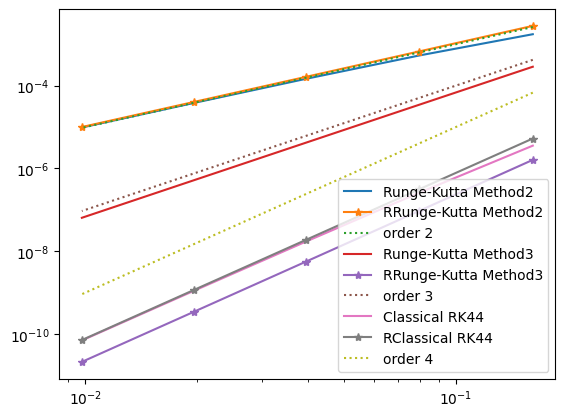

In [6]:
from nodepy import rk
## Convergence
pr=ODEproblem("nonLinearOscillator")
pr.T_fin=5
# Define some explicit RK
A=np.array([[0,0],[1/2,0]])
b=np.array([0,1])
rk2 = rk.ExplicitRungeKuttaMethod(A,b)

A=np.array([[0]])
b=np.array([1])
rk1 = rk.ExplicitRungeKuttaMethod(A,b)


A=np.array([[0,0,0],[2/3,0,0],[1/3,1/3,0]])
b=np.array([1/4,0,3/4])
rk3 = rk.ExplicitRungeKuttaMethod(A,b)

rk44=rk.loadRKM('RK44')



def error(tt,yy):
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-pr.exact(yy[:,0],t))
    return np.mean(errors)

Ns=[2**k for k in range(5,10)]
solvers=[ rk2,rk3,rk44]  #rk1

errorEx  =np.zeros((len(solvers),len(Ns)))
errorRRK =np.zeros((len(solvers),len(Ns)))
dts=    np.zeros(len(Ns))



for iN, N in enumerate(Ns):
    tspan=np.linspace(0,pr.T_fin,N)
    dts[iN]=tspan[1]-tspan[0]
    for iS, rkM in enumerate(solvers):
        tt,yy=explicitRK(pr.flux,tspan,pr.u0,rkM.A,rkM.b,rkM.c)
        errorEx[iS,iN]=error(tt,yy)
        tt,yy, gammas =explicitRelaxRK(pr.flux,pr.u0,dts[iN], pr.T_fin, np.int64(pr.T_fin//dts[iN]*3),\
                              rkM.A,rkM.b,rkM.c)
        errorRRK[iS,iN]=error(tt,yy)

plt.figure()
for iS, rkM in enumerate(solvers):
    orderRK=rkM.order()
    plt.loglog(dts,errorEx[iS,:],label=rkM.name+str(orderRK))
    plt.loglog(dts,errorRRK[iS,:],"*-",label="R"+rkM.name+str(orderRK))
    plt.loglog(dts,dts**(orderRK)/10,":", label="order %d"%(orderRK))
plt.legend()

You should see a superconvergence phenomenon for RRK with odd order. 

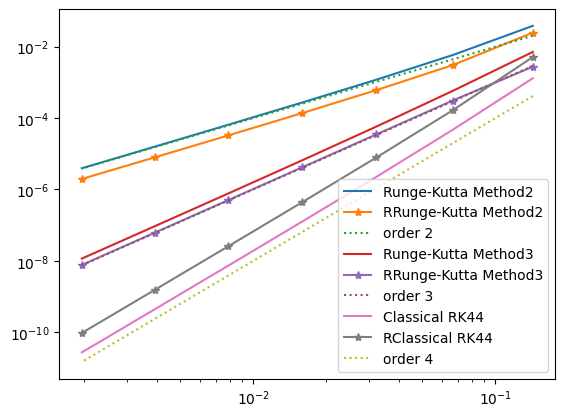

In [7]:
from nodepy import rk
## Convergence
pr=ODEproblem("linear_system2")
# Define some explicit RK
A=np.array([[0,0],[1/2,0]])
b=np.array([0,1])
rk2 = rk.ExplicitRungeKuttaMethod(A,b)

A=np.array([[0]])
b=np.array([1])
rk1 = rk.ExplicitRungeKuttaMethod(A,b)


A=np.array([[0,0,0],[2/3,0,0],[1/3,1/3,0]])
b=np.array([1/4,0,3/4])
rk3 = rk.ExplicitRungeKuttaMethod(A,b)

rk44=rk.loadRKM('RK44')



def error(tt,yy):
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-pr.exact(yy[:,0],t))
    return np.mean(errors)

Ns=[2**k for k in range(3,10)]
solvers=[ rk2,rk3,rk44]  #rk1

errorEx  =np.zeros((len(solvers),len(Ns)))
errorRRK =np.zeros((len(solvers),len(Ns)))
dts=    np.zeros(len(Ns))



for iN, N in enumerate(Ns):
    tspan=np.linspace(0,pr.T_fin,N)
    dts[iN]=tspan[1]-tspan[0]
    for iS, rkM in enumerate(solvers):
        tt,yy=explicitRK(pr.flux,tspan,pr.u0,rkM.A,rkM.b,rkM.c)
        errorEx[iS,iN]=error(tt,yy)
        tt,yy, gammas =explicitRelaxRK(pr.flux,pr.u0,dts[iN], pr.T_fin, np.int64(pr.T_fin//dts[iN]*5),\
                              rkM.A,rkM.b,rkM.c)
        errorRRK[iS,iN]=error(tt,yy)

plt.figure()
for iS, rkM in enumerate(solvers):
    orderRK=rkM.order()
    plt.loglog(dts,errorEx[iS,:],label=rkM.name+str(orderRK))
    plt.loglog(dts,errorRRK[iS,:],"*-",label="R"+rkM.name+str(orderRK))
    plt.loglog(dts,dts**(orderRK),":", label="order %d"%(orderRK))
plt.legend()

In this case, there is no energy to maintain, we recast the original error

### General entropy case
Description and proof can be found in [Ranocha 2019](https://arxiv.org/abs/1905.09129).

#### Motivation
$$
\langle \partial_y \eta(y), F(y) \rangle \stackrel{(\leq)}{=} 0.
$$
Hence, 
$$
\partial_t \eta(y(t)) = \langle \partial_y \eta(y(t)), \partial_t y(t) \rangle = \langle \partial_y \eta(y(t)), F(y(t)) \rangle   \stackrel{(\leq)}{=} 0.
$$
We want to mimic this at the discrete level. Introducing Runge--Kutta:
$$
\begin{cases}
y^{(i)} = y^n +\Delta t \sum_j a_{ij} F(y^{(j)})\\
y^{n+1}=y^n + \Delta t \sum_i b_i F(y^{(i)})
\end{cases}
$$
Taylor expansion!
$$
\begin{align*}
\eta(y^{n+1})-\eta(y^{n}) =& \Delta t \sum_i b_i \langle  \partial_y \eta(y^n), F(y^{(i)})\rangle +  \Delta t \sum_{i,j} b_i b_j \langle F(y^{(i)}), \partial_{yy}\eta(y^n) F(y^{(j)}) \rangle \\
=&\Delta t \sum_i b_i \langle  \partial_y \eta(y^{(i)}), F(y^{(i)})\rangle +\Delta t \sum_i b_i \langle  \partial_y \eta(y^n-y^{(i)}), F(y^{(i)})\rangle \\
&+  \Delta t \sum_{i,j} b_i b_j \langle F(y^{(i)}), \partial_{yy}\eta(y^n) F(y^{(j)}) \rangle\\
=&\Delta t \sum_i b_i \underbrace{\langle  \partial_y \eta(y^{(i)}), F(y^{(i)})\rangle}_{\stackrel{(\leq)}{=} 0} -\Delta t^2 \sum_i \sum_j b_i a_{ij} \langle  \partial_y \eta(F(y^{(j)}), F(y^{(i)})\rangle \\
&+  \Delta t \sum_{i,j} b_i b_j \langle F(y^{(i)}), \partial_{yy}\eta(y^n) F(y^{(j)}) \rangle. 
\end{align*}
$$

#### Method
$$
\begin{cases}
y^{(i)} = y^n +\Delta t \sum_j a_{ij} F(y^{(j)})\\
y^{n+1}_\gamma=y^n + \gamma_n \Delta t \sum_i b_i F(y^{(i)})\\
r(\gamma_n) =\eta(y^{n+1}_\gamma)-\eta(y^{n}) -\gamma_n \Delta t \sum_i b_i \langle \partial_y\eta(y^{(i)}), F(y^{(i)}) \rangle =0
\end{cases}
$$

#### Existence of solution
How do we know that we can find a solution for the scalar equation $r(\gamma_n)=0$?
##### Lemma 2.4 of [Ranocha 2019](https://arxiv.org/pdf/1905.09129.pdf)
Let a RK be such that $\sum_{i,j} b_i a_{ij} >0$ and let $r(\gamma)$ defined as above. If $\partial_{yy}\eta(y^n)(F(y^n),F(y^n)) >0$, then $r'(0) <0$ for sufficiently small $\Delta t>0$.

**Proof**
$$
\begin{align*}
r'(0) &= \Delta t \sum_i b_i \langle \eta' (y^n ), F(y^{(i)})\rangle - \Delta t \sum_i b_i \langle \eta' (y^{(i)} ), F(y^{(i)})\rangle\\
&= \Delta t \sum_i b_i \langle \eta' (y^n ), F(y^{(i)})\rangle - \Delta t \sum_i b_i \langle \eta' (y^n + \Delta t \sum_k a_{ik} F(y^{(k)}) ), F(y^{(i)})\rangle\\
&= -\Delta t \sum_i b_i \int_0^1 \eta'' (y^n + v \Delta t \sum_k a_{ik} F(y^{(k)}) )\left( F(y^{(i)}), \Delta t\sum_j a_{ij} F(y^{(j)}) \right) dv. 
\end{align*}
$$
Using Taylor expansion, we have $F(y^{(i)})=F(y^n)+O(\Delta t)$, so
$$
r'(0) = - \Delta t^2 \sum_{i,j} b_i a_{ij} \eta'' (y^n  )\left(  F(y^n),  F(y^n) \right)  +O(\Delta t^3).
$$
Hence, the statement.

The assumption $\sum_{i,j} b_i a_{ij} >0$ is verified by all RK methods that are at least second order accurate, as $\sum_{i,j} b_i a_{ij} =\frac12$.

##### Lemma 2.6 of [Ranocha 2019](https://arxiv.org/pdf/1905.09129.pdf)
Let a RK be such that $\sum_{i,j} b_i (b_j-a_{ij}) >0$ and let $r(\gamma)$ defined as above. If $\partial_{yy}\eta(y^n)(F(y^n),F(y^n)) >0$, then $r'(1) >0$ for sufficiently small $\Delta t>0$.

**Proof**
$$
\begin{align*}
r'(1) &= \Delta t \sum_i b_i \langle \eta' (y^{n+1} ), F(y^{(i)})\rangle - \Delta t \sum_i b_i \langle \eta' (y^{(i)} ), F(y^{(i)})\rangle\\
&= \Delta t \sum_i b_i \langle \eta' (y^{n} + \Delta t \sum_k b_k F(y^{(k)}) ), F(y^{(i)})\rangle - \Delta t \sum_i b_i \langle \eta' (y^{n} + \Delta t \sum_k a_{ik} F(y^{(k)}) ), F(y^{(i)})\rangle\\
&= \Delta t \sum_i b_i \int_0^1 \eta'' \left( y^n + v \Delta t \sum_k (b_k-a_{ik} ) F(y^{(k)}) \right)\left( F(y^{(i)}), \Delta t\sum_j (b_j-a_{ij}) F(y^{(j)}) \right) dv. 
\end{align*}
$$
Using Taylor expansion, we have $F(y^{(i)})=F(y^n)+O(\Delta t)$, so
$$
r'(1) = \Delta t^2 \sum_{i,j} b_i (b_j-a_{ij}) \eta'' (y^n  )\left(  F(y^n),  F(y^n) \right)  +O(\Delta t^3).
$$
Hence, the statement.

**Remark**
RK that are at least second order verify $\sum_{i,j} b_i (b_j-a_{ij}) = 1-\frac{1}2=\frac12$

##### Theorem 2.8 of [Ranocha 2019](https://arxiv.org/pdf/1905.09129.pdf)
Let a RK be such that $\sum_{i,j} b_i (b_j-a_{ij}) >0$ and $\sum_{i,j} b_i a_{ij} >0$ and let $r(\gamma)$ defined as above. If $\partial_{yy}\eta(y^n)(F(y^n),F(y^n)) >0$, then $r(\gamma) >0$ has a positive root ($\gamma_n\neq 0$) for sufficiently small $\Delta t>0$.

**Proof**

Since $r(0)=0$ and $r'(0)<0$ $r(\gamma)$ for small $\gamma >0$ is negative. Since $r$ is convex $r'$ is monotone, and since $r'(1)>0$  there must be a positive root of $r$.

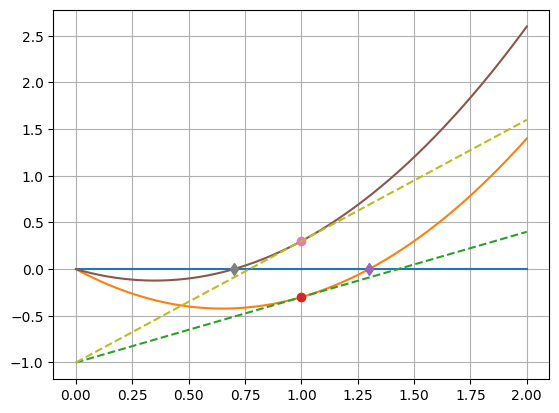

In [8]:
# Visual intuition of the proof
xx=np.linspace(0,2,1000)
yy1= xx*(xx-1.3)
yy_tan1 = ((1.-1.3)+1.)*xx -1.
yy2= xx*(xx-0.7)
yy_tan2 = ((1.-0.7)+1.)*xx -1.
zz=xx*0.
plt.plot(xx,zz)
plt.plot(xx,yy1)
plt.plot(xx,yy_tan1,"--")
plt.plot(1,1-1.3,'o')
plt.plot(1.3,0,'d')
plt.plot(xx,yy2)
plt.plot(1,1-.7,'o')
plt.plot(.7,0,'d')
plt.plot(xx,yy_tan2,"--")
plt.grid(True)

#### Accuracy (sketch)
RRK do not lose accuracy wrt the original method, even if it seems that the method described above is not even consistent, since $\gamma_n \sum_j b_j=\gamma_n \neq 1$ in general. 
The following result has been obtained in [27, Theorem 2.4].
##### Theroem 3 [Ketcheson 2019](https://arxiv.org/abs/1905.09847)
Let the given Runge–Kutta method be of order $p$. Consider the RRK method defined
above and suppose that $\gamma_n=1+O(\Delta t^{p-1})$. Then,
the relaxation method interpreting $y^{n+1}_\gamma \approx y(t^n+\gamma_n \Delta t ) $ has order p.

##### Theorem 2.15 [Ranocha 2019](https://arxiv.org/pdf/1905.09129.pdf)
Let a RK be such that $\sum_{i,j} b_i (b_j-a_{ij}) >0$ and $\sum_{i,j} b_i a_{ij} >0$ of order $p$ and let $r(\gamma)$ defined as above. If $\partial_{yy}\eta(y^n)(F(y^n),F(y^n)) >0$, then $r(\gamma) >0$ has a positive root ($\gamma_n\neq 0$) for sufficiently small $\Delta t>0$.
Then $\gamma_n=1+O(\Delta t^{p-1})$.

**Proof sketch**
* $r(1)=O(\Delta t^{p+1})$
$$
\begin{align*}
r(\gamma=1) &=\eta(y^{n+1})-\eta(y^{n}) - \Delta t \sum_i b_i \langle \partial_y\eta(y^{(i)}), F(y^{(i)}) \rangle \\
&= \int_{t^n}^{t^{n+1}} \partial_t \eta(y(t)) dt - \Delta t \sum_i b_i \langle \partial_y\eta(y(t^{(i)})), F(y(t^{(i)})) \rangle+ O(\Delta t^{p+1})\\
&= \int_{t^n}^{t^{n+1}} \langle \partial_y \eta(y(t)), F(y(t)) dt - \Delta t \sum_i b_i \langle \partial_y\eta(y(t^{(i)})), F(y(t^{(i)})) \rangle+ O(\Delta t^{p+1}) \\
&= O(\Delta t^{p+1}) 
\end{align*}
$$
* $r'(1) = \Theta(\Delta t^2)$
* $\gamma_n=1+O(\Delta t^{p-1})$


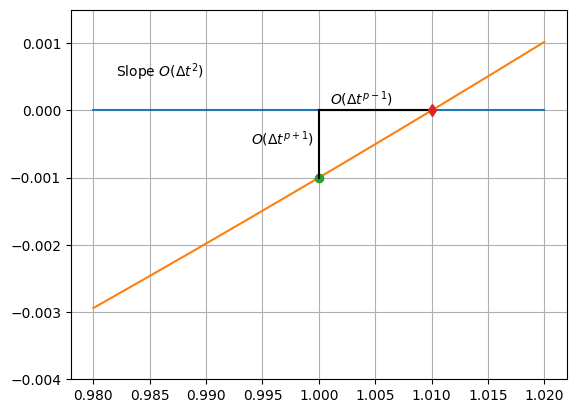

In [9]:
# Visual intuition of the proof
gamma=1.01
xx=np.linspace(0.98,1.02,1000)
yy1= 0.1*xx*(xx-gamma)
#yy_tan1 = 0.1*((1.-gamma)+1.)*xx -1.
zz=xx*0.
plt.plot(xx,zz)
plt.plot(xx,yy1)
#plt.plot(xx,yy_tan1,"--")
plt.plot(1,0.1*(1-gamma),'o')
plt.plot([1,1],[0.1*(1-gamma),0],"k")
plt.text(0.994,-0.0005,"$O(\Delta t^{p+1})$")
plt.text(0.982,0.0005,"Slope $O(\Delta t^{2})$")
plt.plot([1,gamma],[0, 0],"k")
plt.text(1.001,0.0001,"$O(\Delta t^{p-1})$")
plt.plot(gamma,0,'d')
plt.ylim([-0.004,0.0015])
plt.grid(True)

**Pro exercise: code the relaxation RK for a general entropy**
* $\frac{d}{dt} \eta(y(t)) \stackrel{(\leq)}{=}0 $ and $\langle \partial_u \eta (y), y \rangle \stackrel{(\leq)}{=}0 $
* The final equation can be a nonlinear equation in $\gamma$, hence a nonlinear solver must be used, try with **scipy.optimize.newton** or .broyden1
* The extra input we need are the entropy function $\eta(y)$ and the entropy variables function $\partial_y \eta(y)$
* Final relation that should hold is

$$
\eta(y^{n+1}_\gamma)-\eta(y^0)- \gamma \Delta t \sum_{j=1}^S b_j \langle \partial_y \eta(y^{(j)}), F(y^{(j)}) \rangle=0
$$

In [10]:
from scipy import optimize
## explicit RK method
def explicitRelaxRKEntropy(flux, entropy, e_v, y_0, dt0, T_fin, KtMax,  A, b, c):
    # Solving u'=F(u,t)
    # input: flux=F, tspan is a vector of times determining the RK steps
    # entropy: scalar function of y
    # entropy variable e_v: vector function of y
    # input: y_0 the initial condition
    # dt0 is the basic time interval, that will be modified along the steps
    # T_fin is the final time
    # KtMax is maximum number of timesteps
    # input: A,b,c are matrix and vectors of RK methods
    dim=len(y_0)          # S
    y=np.zeros((dim,KtMax))    # initializing the variable of solutions
    tspan=np.zeros(KtMax)      # times will be stored here
    gammas = np.zeros(KtMax)   # Gamma relaxation coefficients
    time= 0.
    gammas[0] = 1
    n=0                        # Time step index
    tspan[0] = time
    y[:,0]=y_0                 # first timestep 
    S=np.shape(A)[0]
    u=np.zeros((dim,S))       # Internal stages
    Fu=np.zeros((dim,S))       # Flux at internal stages
    while(time<T_fin and n<KtMax):    # n=0,..., N-1
        ent0=entropy(y[:,n])
        e_v0 = e_v(y[:,n])
        delta_t=min(dt0,T_fin-time)
        #Classic RK step
        for k in range(S):
            u[:,k]=y[:,n] 
            for j in range(k):
                u[:,k] = u[:,k]+ delta_t*A[k,j]*Fu[:,j]
            Fu[:,k] = flux(u[:,k],tspan[n]+delta_t*c[k])
        yn1=y[:,n]
        for j in range(S):
            yn1=yn1+delta_t*b[j]*Fu[:,j]
        # Compute the relaxation gamma
        deltay = yn1-y[:,n]
        sumBScal=0.
        for j in range(S):
            sumBScal=sumBScal + b[j]* np.dot(e_v(u[:,j]),Fu[:,j])
        def residual(gamma):
            yn1gamma = np.array(y[:,n]+gamma*deltay,dtype=np.float64)
            res = entropy(yn1gamma)-ent0-gamma*delta_t*sumBScal
            return np.array(res, dtype=np.float64)
        def deriv_res(gamma):
            yn1gamma = np.array(y[:,n]+gamma*deltay,dtype=np.float64)
            resPrime = np.dot(e_v(yn1gamma),deltay)-delta_t*sumBScal
            return  np.array(resPrime, dtype=np.float64)
        gamma = optimize.newton(residual,np.array([1.]),fprime=deriv_res,tol=10**-14) #broyden1(residual,1.,f_tol=10**-13)
        # Update the n+1 values
        y[:,n+1]=y[:,n] +gamma*deltay
        if (time+delta_t<T_fin -10**-16):
            time = time + gamma*delta_t
        else:
            time=T_fin
        tspan[n+1]=time
        gammas[n+1]=gamma
        n=n+1
        
    return tspan[:n+1], y[:,:n+1] , gammas[:n+1]

/tmp/ipykernel_131242/1313860702.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tspan[n+1]=time
/tmp/ipykernel_131242/1313860702.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gammas[n+1]=gamma


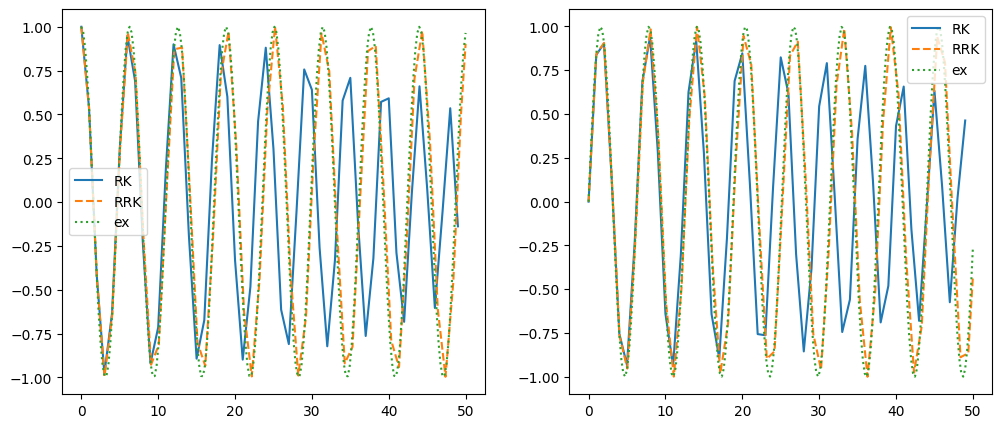

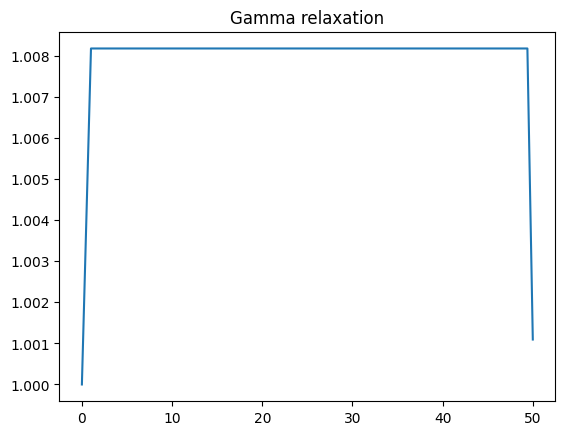

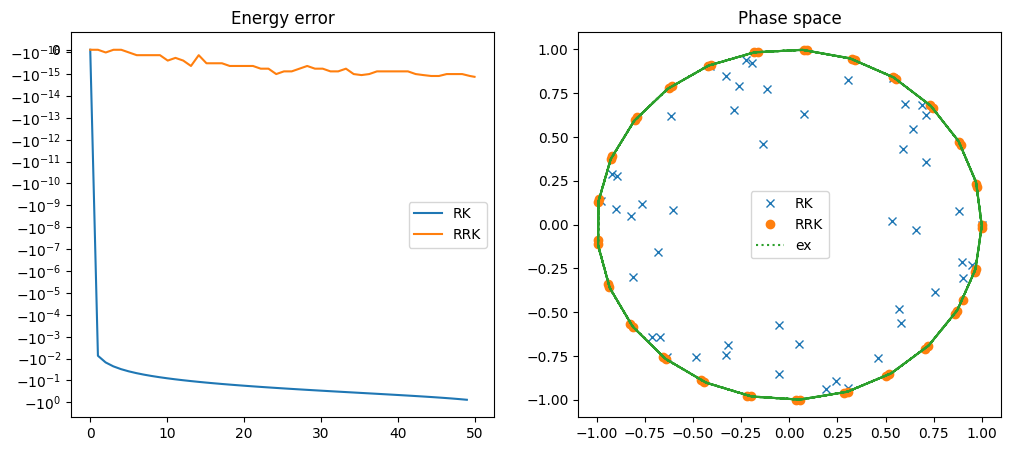

In [11]:
pr=ODEproblem("nonLinearOscillator")
dt0=1  #0.5
entropy = lambda y: (y[0]**2.+y[1]**2.)/2.  ##y[1]**2/2.-np.cos(y[0])
e_v= lambda y: y #np.array([ np.sin(y[0]), y[1] ])
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRKEntropy(pr.flux, entropy, e_v, pr.u0, dt0, pr.T_fin, np.int64(pr.T_fin//dt0*5),  rk44.A, rk44.b, rk44.c)

tEx=np.linspace(0,pr.T_fin, 200)
uEx=np.zeros((uu.shape[0], len(tEx)))
for k in range(len(tEx)):
    uEx[:,k] = pr.exact(pr.u0,tEx[k])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")
plt.plot(tEx,uEx[0,:],":",label="ex")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")
plt.plot(tEx,uEx[1,:],":",label="ex")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[np.dot(uuR[:,k],uuR[:,k])-np.dot(pr.exact(pr.u0,ttR[k]),pr.exact(pr.u0,ttR[k])) for k in range(len(ttR))]
errorEnRK=[np.dot(uu[:,k],uu[:,k])-np.dot(pr.exact(pr.u0,tt[k]),pr.exact(pr.u0,tt[k])) for k in range(len(tt))]
plt.plot(tt,errorEnRK,label="RK")
plt.plot(ttR,errorEnRRK,label="RRK")
plt.title("Energy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uEx[0,:],uEx[1,:], ":", label="ex")
plt.legend()

/tmp/ipykernel_131242/1313860702.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tspan[n+1]=time
/tmp/ipykernel_131242/1313860702.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gammas[n+1]=gamma


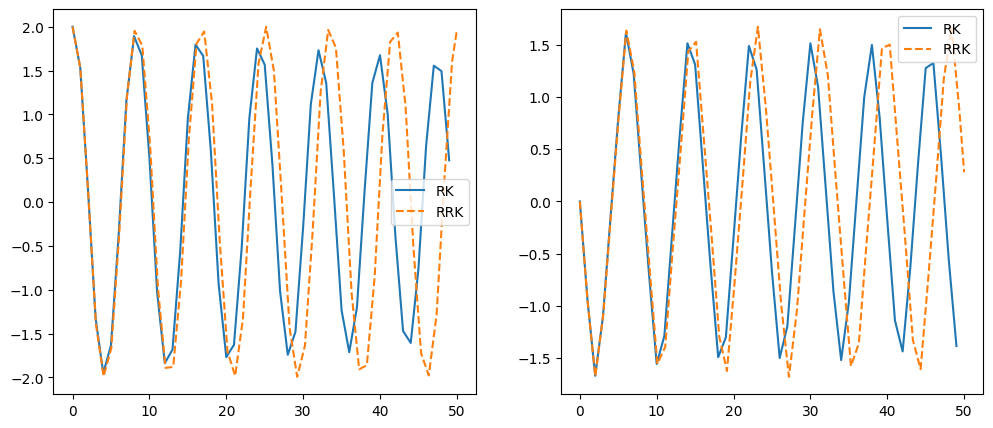

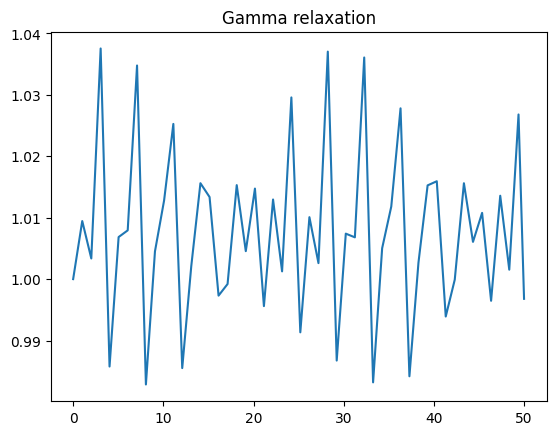

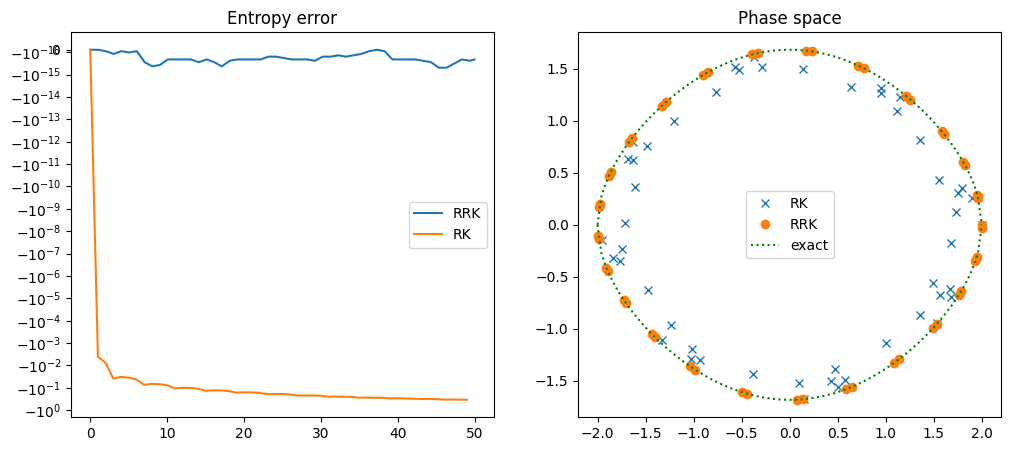

In [12]:
pr=ODEproblem("pendulum")
dt0=1  #0.5
entropy = pr.entropy
e_v= pr.entropy_variable
pr.u0=np.array([2.0,0.])
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRKEntropy(pr.flux, entropy, e_v, pr.u0, dt0, pr.T_fin, np.int64(pr.T_fin//dt0*5),  rk44.A, rk44.b, rk44.c)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[entropy(uuR[:,k])-entropy(uuR[:,0]) for k in range(len(ttR))]
errorEnRK=[entropy(uu[:,k])-entropy(uu[:,0]) for k in range(len(tt))]
plt.plot(ttR,errorEnRRK,label="RRK")
plt.plot(tt,errorEnRK,label="RK")
plt.title("Entropy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
uLin=np.linspace(-2,2,100)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot(uLin,np.sqrt(2.*np.cos(uLin)+2.*entropy(uu[:,0])),"g:",label="exact")
plt.plot(uLin,-np.sqrt(2.0*np.cos(uLin)+2.*entropy(uu[:,0])),"g:")
plt.plot()
plt.legend()

/tmp/ipykernel_131242/1313860702.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tspan[n+1]=time
/tmp/ipykernel_131242/1313860702.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gammas[n+1]=gamma


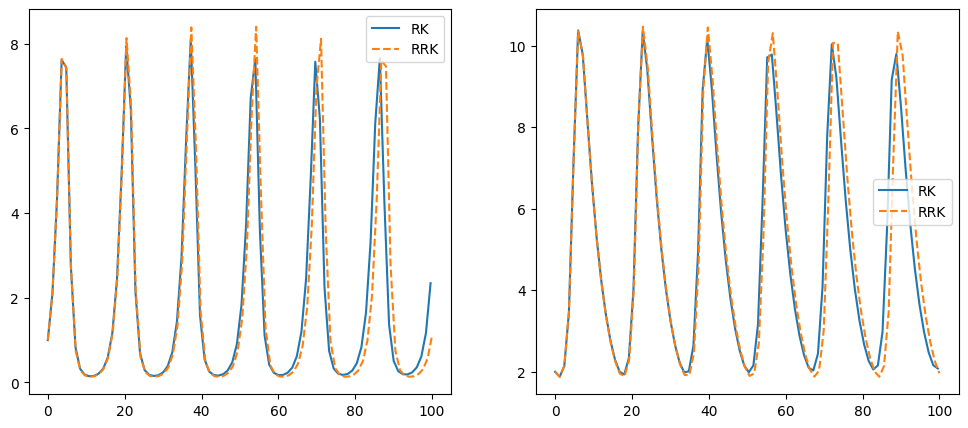

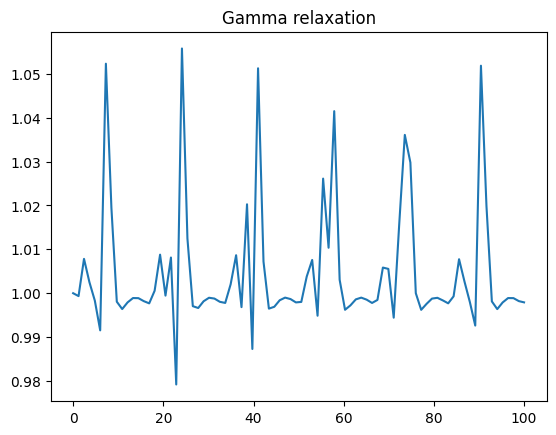

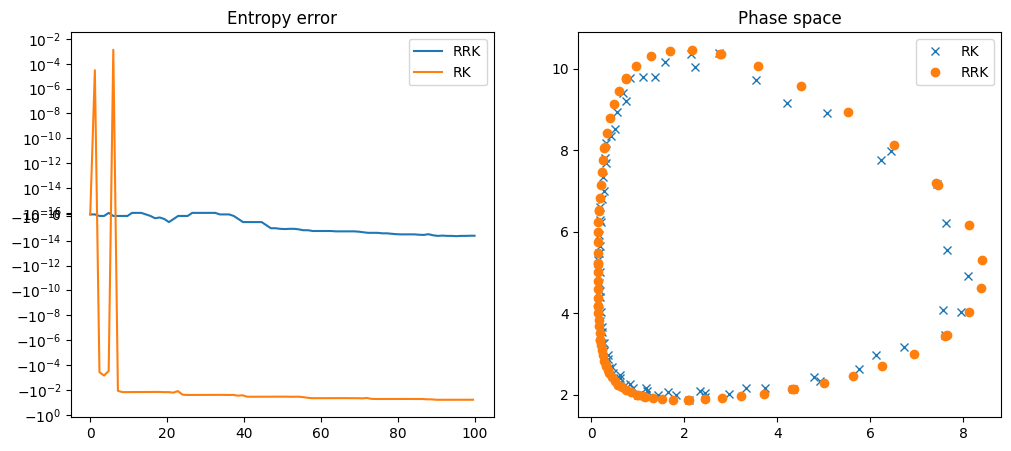

In [13]:
pr=ODEproblem("lotka")
dt0=1.2  #0.5
entropy = pr.entropy
e_v= pr.entropy_variable
t_span=np.arange(0,pr.T_fin+10**-16,dt0)
rk44=rk.loadRKM('RK44')
tt,uu=explicitRK(pr.flux,t_span,pr.u0,rk44.A,rk44.b,rk44.c)
ttR,uuR, gammas = explicitRelaxRKEntropy(pr.flux, entropy, e_v, pr.u0, dt0, pr.T_fin, np.int64(pr.T_fin//dt0*5),  rk44.A, rk44.b, rk44.c)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tt,uu[0,:],label="RK")
plt.plot(ttR,uuR[0,:],"--",label="RRK")

plt.legend()

plt.subplot(122)
plt.plot(tt,uu[1,:],label="RK")
plt.plot(ttR,uuR[1,:],"--",label="RRK")

plt.legend()

plt.figure()
plt.plot(ttR,gammas)
plt.title("Gamma relaxation")


plt.figure(figsize=(12,5))
plt.subplot(121)
errorEnRRK=[entropy(uuR[:,k])-entropy(uuR[:,0]) for k in range(len(ttR))]
errorEnRK=[entropy(uu[:,k])-entropy(uu[:,0]) for k in range(len(tt))]
plt.plot(ttR,errorEnRRK,label="RRK")
plt.plot(tt,errorEnRK,label="RK")
plt.title("Entropy error")
plt.legend()
plt.yscale("symlog",linthresh=1e-15)

plt.subplot(122)
uLin=np.linspace(-2,2,100)
plt.title("Phase space")
plt.plot(uu[0,:],uu[1,:], "x", label="RK")
plt.plot(uuR[0,:],uuR[1,:], "o", label="RRK")
plt.plot()
plt.legend()